<a href="https://colab.research.google.com/github/jeanlucjackson/w266_final_project/blob/main/code/evaluation/evaluate_inferences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Google Drive Mounting

In [3]:
from os import listdir
from os.path import isfile, join

import csv
import json
import pprint

import numpy as np
import pandas as pd
from tqdm import tqdm

# For loading the Universal Sentence Encoder
import tensorflow_hub as hub

In [4]:
# This cell will authenticate you and mount your Drive in the Colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
inference_root = "/content/drive/MyDrive/w266 NLP Final Project/Predictions/"
evaluation_root = "/content/drive/MyDrive/w266 NLP Final Project/Evaluation/"

In [6]:
inference_files = listdir(inference_root)
print(len(inference_files), 'files')
pprint.pprint(inference_files)

62 files
['T5 short model prediction archive',
 'checkpoint',
 'predictions.T5_base_pt_long.nq.nq.csv',
 'predictions.T5_base_pt_long.nq.squad.csv',
 'predictions.T5_base_pt_long.triviaqa.squad.csv',
 'predictions.T5_base_pt_long.nq.quac.csv',
 'predictions.T5_base_pt_long.nq.triviaqa.csv',
 'predictions.T5_base_pt_long.triviaqa.quac.csv',
 'predictions.T5_base_pt_long.triviaqa.nq.csv',
 'predictions.T5_base_pt_long.squad.squad.csv',
 'predictions.T5_base_pt_long.squad.nq.csv',
 'predictions.T5_base_pt_long.squad.triviaqa.csv',
 'predictions.T5_base_pt_long.quac.squad.csv',
 'predictions.T5_base_pt_long.quac.nq.csv',
 'predictions.T5_base_pt_long.squad.quac.csv',
 'predictions.T5_base_pt_long.quac.quac.csv',
 'predictions.T5_base_pt_long.quac.triviaqa.csv',
 'predictions.T5_base_pt_long.triviaqa.triviaqa.csv',
 'predictions.bart_base_pt_long.squad.nq.csv',
 'predictions.bart_base_pt_long.squad.quac.csv',
 'predictions.bart_base_pt_long.squad.squad.csv',
 'predictions.bart_base_pt_long.


# Load Data

Inferences will be saved into the `inference_dict` nested dictionary, whose format is:
- keys: CSV filenames
- values:
  - `target`: list of target values
  - `prediction`: list of prediction values

In [7]:
inference_dict = {}

print('Skipping files that are not CSV format.')
print('________________________________________\n')

for id, inf_file in enumerate(inference_files):

  # Load CSV file containing predictions
  filename = join(inference_root, inf_file)
  suffix = filename.split('.')[-1].strip()
  
  # If the file exists, load it into pandas
  if isfile(filename) and suffix == 'csv':
    print(f"Opening file {id + 1} of {len(inference_files)}: {inf_file}\n")

    df = pd.read_csv(filename)
    
    # If the CSV does not have correct column names, warn user and skip file
    if 'target' not in df.columns and 'prediction' not in df.columns:
      print("WARNING: Columns `target` and `prediction` not found in CSV. Skipping CSV.")
      print(f"Check file: {filename}")
      # continue

    # Columns exist, so continue
    else:
      targets = df['target']
      predictions = df['prediction']

      print('CSV loaded.')
      print(f"Length of targets:      {len(targets)}")
      print(f"Length of predictions:  {len(predictions)}")
      
      # Save lists into prediction dictionary under file's name
      inference_dict.update(
          {inf_file: {'target': targets,
                      'prediction': predictions}
          }
      )
      print('\nTargets and predictions saved.')
    
    print('________________________________________\n')


print(f"\nTotal of {len(inference_dict.keys())} datasets loaded:")
for dataset in inference_dict.keys():
  print('    ' + dataset)

Skipping files that are not CSV format.
________________________________________

Opening file 3 of 62: predictions.T5_base_pt_long.nq.nq.csv

CSV loaded.
Length of targets:      2356
Length of predictions:  2356

Targets and predictions saved.
________________________________________

Opening file 4 of 62: predictions.T5_base_pt_long.nq.squad.csv

CSV loaded.
Length of targets:      10570
Length of predictions:  10570

Targets and predictions saved.
________________________________________

Opening file 5 of 62: predictions.T5_base_pt_long.triviaqa.squad.csv

CSV loaded.
Length of targets:      10570
Length of predictions:  10570

Targets and predictions saved.
________________________________________

Opening file 6 of 62: predictions.T5_base_pt_long.nq.quac.csv

CSV loaded.
Length of targets:      5868
Length of predictions:  5868

Targets and predictions saved.
________________________________________

Opening file 7 of 62: predictions.T5_base_pt_long.nq.triviaqa.csv

CSV loaded.
L

We'll be using:
- ROUGE
- BLEU-RT
- BERTScore
- METEOR
- USE

And storing evaluations in `evaluation_dict` formatted as:
- keys: CSV filenames
- values:
  - metric_name: metric_value

# Load Evaluation Metrics

In [8]:
!pip install -q evaluate
import evaluate

     |████████████████████████████████| 72 kB 1.4 MB/s 
     |████████████████████████████████| 212 kB 35.8 MB/s 
     |████████████████████████████████| 115 kB 50.1 MB/s 
     |████████████████████████████████| 182 kB 69.6 MB/s 
     |████████████████████████████████| 451 kB 63.0 MB/s 
     |████████████████████████████████| 127 kB 69.0 MB/s 


## ROUGE
🤗 [ROUGE page](https://huggingface.co/spaces/evaluate-metric/rouge)

In [9]:
!pip install -q rouge_score

rouge = evaluate.load('rouge')

## BLEU

🤗 BLEU page

In [10]:
bleu = evaluate.load("bleu")

## BLEU-RT
- No fine-tuning yet.
- Using `BLEURT-20` checkpoint per Google's recommendation (see [BLEURT GitHub page](https://github.com/google-research/bleurt/blob/master/checkpoints.md#the-recommended-checkpoint-bleurt-20))

In [11]:
!pip install git+https://github.com/google-research/bleurt.git

bleurt = evaluate.load('bleurt', module_type='metric', checkpoint='BLEURT-20-D3')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-wtxkziz4
  Running command git clone -q https://github.com/google-research/bleurt.git /tmp/pip-req-build-wtxkziz4
     |████████████████████████████████| 352 kB 12.7 MB/s 
     |████████████████████████████████| 1.3 MB 59.3 MB/s 
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456782 sha256=4672b3987c6b6ec12c311bbcca4085b46818b51805b5f89e8e2f95ff48198e1a
  Stored in directory: /tmp/pip-ephem-wheel-cache-74a_s8ou/wheels/e2/2d/ea/b7a8b2424d2908d2a79d73ce8217d5ac4bd97ed3f47160a7f5
Successfully built BLEURT


## BERTScore
🤗 [BERTScore page](https://huggingface.co/spaces/evaluate-metric/bertscore)
- Using `distilbert-base-uncased` per 🤗 recommendation because the default model (`roberta-large`) is over 1.4GB

In [12]:
!pip install bert_score

bertscore = evaluate.load('bertscore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 6.2 MB/s 
     |████████████████████████████████| 5.5 MB 29.9 MB/s 
     |████████████████████████████████| 7.6 MB 52.8 MB/s 


## METEOR
🤗 [METEOR page](https://huggingface.co/spaces/evaluate-metric/meteor)

In [13]:
meteor = evaluate.load('meteor')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Universal Sentence Encoder (USE)
Loaded from [TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder#load_the_universal_sentence_encoders_tf_hub_module)

In [14]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


# Calculate Metrics on Each Dataset

Metrics are calculated for each `target` – `prediction` pair. The metric for each pair is saved **in a list** so that statistics can be calculated on all predictions. This also enables manual inspection of high- and low-scoring predictions.

## Evaluation Dictionary

There are 3 options for the creation/updating of the `evaluation_dict`. Use the values below for the `eval_dict_option` argument:

1. `empty`: Create an empty dictionary and evaluate all metrics from scratch.
2. `load`: Load a previously created dictionary.
3. `add`: Load a previously created dictionary and add evaluations that have not been calculated yet.

In [18]:
# Use "empty", "load", or "add" - see description above
eval_dict_option = 'empty'

In [19]:
# Standard filename for `evaluation_dict` saved in Google Drive
filename = join(evaluation_root, "evaluation_dict.json")

# List of datasets that need evaluations
datasets_to_eval = []

# Check dictionary creation option set by user
if eval_dict_option == 'empty':
  evaluation_dict = {}
  datasets_to_eval += list(inference_dict.keys())

elif eval_dict_option == 'load':
  # Load JSON
  with open(filename) as json_file:
    evaluation_dict = json.load(json_file)

elif eval_dict_option == 'add':
  # Load JSON
  with open(filename) as json_file:
    evaluation_dict = json.load(json_file)

    # Find keys not present in existing dict
    available_datasets = inference_dict.keys()
    evaluated_datasets = evaluation_dict.keys()

    for key in available_datasets:
      if key not in evaluated_datasets:
        datasets_to_eval.append(key)

print(f"'{eval_dict_option}' option selected.\n")
print("Datasets that will be evaluated on each metric:")
pprint.pprint(datasets_to_eval)

'empty' option selected.

Datasets that will be evaluated on each metric:
['predictions.T5_base_pt_long.nq.nq.csv',
 'predictions.T5_base_pt_long.nq.squad.csv',
 'predictions.T5_base_pt_long.triviaqa.squad.csv',
 'predictions.T5_base_pt_long.nq.quac.csv',
 'predictions.T5_base_pt_long.nq.triviaqa.csv',
 'predictions.T5_base_pt_long.triviaqa.quac.csv',
 'predictions.T5_base_pt_long.triviaqa.nq.csv',
 'predictions.T5_base_pt_long.squad.squad.csv',
 'predictions.T5_base_pt_long.squad.nq.csv',
 'predictions.T5_base_pt_long.squad.triviaqa.csv',
 'predictions.T5_base_pt_long.quac.squad.csv',
 'predictions.T5_base_pt_long.quac.nq.csv',
 'predictions.T5_base_pt_long.squad.quac.csv',
 'predictions.T5_base_pt_long.quac.quac.csv',
 'predictions.T5_base_pt_long.quac.triviaqa.csv',
 'predictions.T5_base_pt_long.triviaqa.triviaqa.csv',
 'predictions.bart_base_pt_long.squad.nq.csv',
 'predictions.bart_base_pt_long.squad.quac.csv',
 'predictions.bart_base_pt_long.squad.squad.csv',
 'predictions.bart_b

## ROUGE

In [ ]:
for id, dataset in enumerate(datasets_to_eval):
  print(f"{id+1}/{len(datasets_to_eval)}: Evaluating ROUGE on {dataset}...", end=' ')

  targets = inference_dict[dataset]['target'].tolist()
  predictions = inference_dict[dataset]['prediction'].tolist()

  # ROUGE scores
  # The use_aggregator argument takes the average for us.
  # Set to False to save the list of scores and not just the average.
  rouge_results = rouge.compute(predictions=predictions,
                                references=targets,
                                use_aggregator=False)
  
  for metric in rouge_results:
    
    # If this dataset hasn't been added to dict, add it and metric
    if not evaluation_dict.get(dataset):
      evaluation_dict.update(
            {
                dataset: {
                    metric: rouge_results[metric]
                         }
            }
        )
      
    # This dataset already exists as a key, so add this metric
    else:
      evaluation_dict[dataset].update(
          {
              metric: rouge_results[metric]
          }
      )
  
  print('Done.')


In [ ]:
evaluation_dict[datasets_to_eval[0]].keys()

In [ ]:
len(evaluation_dict[datasets_to_eval[0]]['rougeL'])

In [ ]:
# `evaluation_dict` as JSON
filename = join(evaluation_root, "evaluation_dict.json")
with open(filename, "w") as outfile:
  json.dump(evaluation_dict, outfile)
  print(f'JSON saved at {filename}')

## BLEU

In [ ]:
for id, dataset in enumerate(datasets_to_eval):
  print(f"{id+1}/{len(datasets_to_eval)}: Evaluating BLEU on {dataset}...", end=' ')

  targets = inference_dict[dataset]['target'].tolist()
  predictions = inference_dict[dataset]['prediction'].tolist()

  bleu_results_list = []

  # BLEU takes a pair of inputs at a time
  for pair in zip(predictions, targets):
    
    # Calculate BLEU score for this pair
    results = bleu.compute(predictions=[pair[0]],
                           references=[pair[1]])
    
    bleu_results_list.append(results['bleu'])
  
  
  # Add BLEU to dictionary
  # If this dataset hasn't been added to dict, add it and metric
  if not evaluation_dict.get(dataset):
    evaluation_dict.update(
          {
              dataset: {'bleu': bleu_results_list}
          }
      )
    
  # This dataset already exists as a key, so add this metric
  else:
    evaluation_dict[dataset].update(
        {
            'bleu': bleu_results_list
        }
    )

  print('Done.')


# Save `evaluation_dict` to JSON
filename = join(evaluation_root, "evaluation_dict.json")
with open(filename, "w") as outfile:
  json.dump(evaluation_dict, outfile)
  print(f'    JSON saved at {filename}')

## BLEU-RT

In [ ]:
# Copy a dataset name string from above and paste below
# or set to None to evaluate all of them.
begin_at = None

In [ ]:
# Used to control which dataset to resume evaluation at
play = False

for id, dataset in enumerate(datasets_to_eval):

  # Do not evaluate until we reach the `begin_at` dataset
  if dataset == begin_at or begin_at is None:
    play = True
  
  # If `play` is True, we've reached the dataset and can resume evaluation
  if play:
    print(f"{id+1}/{len(datasets_to_eval)}: Evaluating BLEU-RT on {dataset}...", end=' ')

    targets = inference_dict[dataset]['target'].tolist()
    predictions = inference_dict[dataset]['prediction'].tolist()

    # BLEU-RT scores
    bleurt_results = bleurt.compute(predictions=predictions,
                                    references=targets)
    
    # Average over scores
    bleurt_scores_list = bleurt_results['scores']
    # avg_bleurt = sum(bleurt_scores_list) / len(bleurt_scores_list)
      
    # If this dataset hasn't been added to dict, add it and metric
    if not evaluation_dict.get(dataset):
      evaluation_dict.update(
            {
                dataset: {'bleurt': bleurt_scores_list},
            }
        )
      
    # This dataset already exists as a key, so add this metric
    else:
      evaluation_dict[dataset].update(
          {
              'bleurt': bleurt_scores_list
          }
      )
    
    print('Done.')

    # Save this version of `evaluation_dict` as JSON in case Colab dies out
    filename = join(evaluation_root, "evaluation_dict.json")
    with open(filename, "w") as outfile:
      json.dump(evaluation_dict, outfile)
      print(f'    JSON saved at {filename}')

  # If `play` is False, we have not reached the `begin_at` dataset yet
  else:
    print(f"Skipping {dataset}.")


## BERTScore

In [ ]:
for id, dataset in enumerate(datasets_to_eval):
  print(f"{id+1}/{len(datasets_to_eval)}: Evaluating BERTScore on {dataset}...", end=' ')

  targets = inference_dict[dataset]['target'].tolist()
  predictions = inference_dict[dataset]['prediction'].tolist()

  # BERT Scores
  bertscore_results = bertscore.compute(predictions=predictions,
                                        references=targets,
                                        model_type='distilbert-base-uncased')
  
  # Average over scores
  bertscore_precision_list = bertscore_results['precision']
  bertscore_recall_list = bertscore_results['recall']
  bertscore_f1_list = bertscore_results['f1']

  # avg_precision = sum(bertscore_precision_list) / len(bertscore_precision_list)
  # avg_recall = sum(bertscore_recall_list) / len(bertscore_recall_list)
  # avg_f1 = sum(bertscore_f1_list) / len(bertscore_f1_list)
    
  # If this dataset hasn't been added to dict, add it and metric
  if not evaluation_dict.get(dataset):
    evaluation_dict.update(
          {
              dataset: {'bertscore-precision': bertscore_precision_list,
                        'bertscore-recall': bertscore_recall_list,
                        'bertscore-f1': bertscore_f1_list}
          }
      )
    
  # This dataset already exists as a key, so add this metric
  else:
    evaluation_dict[dataset].update(
        {
            'bertscore-precision': bertscore_precision_list,
            'bertscore-recall': bertscore_recall_list,
            'bertscore-f1': bertscore_f1_list
        }
    )
  
  print('Done.')

  # Save this version of `evaluation_dict` as JSON in case Colab dies out
  filename = join(evaluation_root, "evaluation_dict.json")
  with open(filename, "w") as outfile:
    json.dump(evaluation_dict, outfile)
    print(f'    JSON saved at {filename}')


## METEOR

In [ ]:
for id, dataset in enumerate(datasets_to_eval):
  print(f"{id+1}/{len(datasets_to_eval)}: Evaluating METEOR on {dataset}...", end=' ')

  targets = inference_dict[dataset]['target'].tolist()
  predictions = inference_dict[dataset]['prediction'].tolist()

  meteor_results_list = []

  # METEOR takes a pair of inputs at a time
  for pair in zip(predictions, targets):
    
    # Calculate METEOR scores
    results = meteor.compute(predictions=[pair[0]],
                             references=[pair[1]])
    
    meteor_results_list.append(results['meteor'])
  
  # avg_meteor = sum(meteor_results_list) / len(meteor_results_list)

  # Add METEOR to dictionary
  # If this dataset hasn't been added to dict, add it and metric
  if not evaluation_dict.get(dataset):
    evaluation_dict.update(
        {
            dataset: {'meteor': meteor_results_list}
        }
    )
  
  # This dataset already exists as a key, so add this metric
  else:
      evaluation_dict[dataset].update(
          {
              'meteor': meteor_results_list
          }
      )

  print('Done.')

  # Save this version of `evaluation_dict` as JSON in case Colab dies out
  filename = join(evaluation_root, "evaluation_dict.json")
  with open(filename, "w") as outfile:
    json.dump(evaluation_dict, outfile)
    print(f'    JSON saved at {filename}')


## Universal Sentence Encoder (USE)

In [1]:
def use_embed(input):
  return model(input)

In [ ]:
for id, dataset in enumerate(datasets_to_eval):
  print(f"{id+1}/{len(datasets_to_eval)}: Evaluating USE on {dataset}...", end=' ')

  targets = inference_dict[dataset]['target'].tolist()
  predictions = inference_dict[dataset]['prediction'].tolist()

  use_results_list = []

  # USE takes a pair of inputs at a time
  for pair in zip(targets, predictions):
    
    # Calculate USE embeddings for this pair
    embeds = use_embed(
        [
          pair[0], # target
          pair[1]  # prediction
        ]
    )

    # Calculate correlation between embeddings
    corr = np.inner(embeds, embeds)

    # Grab prediction's correlation score
    pred_corr = corr[0].tolist()[1]
    
    # Add to results list
    use_results_list.append(pred_corr)
  
  
  # Add USE to dictionary
  # If this dataset hasn't been added to dict, add it and metric
  if not evaluation_dict.get(dataset):
    evaluation_dict.update(
          {
              dataset: {'use': use_results_list}
          }
      )
    
  # This dataset already exists as a key, so add this metric
  else:
    evaluation_dict[dataset].update(
        {
            'use': use_results_list
        }
    )

  print('Done.')


# Save `evaluation_dict` to JSON
filename = join(evaluation_root, "evaluation_dict.json")
with open(filename, "w") as outfile:
  json.dump(evaluation_dict, outfile)
  print(f'    JSON saved at {filename}')

1/60: Evaluating USE on predictions.T5_base_pt_long.nq.nq.csv... Done.
2/60: Evaluating USE on predictions.T5_base_pt_long.nq.squad.csv... 

# Model Metric Database DataFrame

Create an `evaluation_db` DataFrame to save all `target`, `prediction`, and metrics for all models. Saving them all in one DF allows for filtering by model name to perform analysis, easily taking advantage of Panda's filtering and analytic tools.

In [23]:
# Save all `target`, `prediction`, and metrics in single database
evaluation_db_df = pd.DataFrame()

# Loop through `evaluation_dict` and create database DF containing all datasets
for dataset, metrics in evaluation_dict.items():

  # Fetch `target` `prediction` columns from `inference_dict`
  infer_df = pd.DataFrame.from_dict(inference_dict[dataset],
                                    orient='columns')
  
  # Fetch evaluation scores from `evaluation_dict`
  metric_df = pd.DataFrame.from_dict(metrics,
                                     orient='columns')
  # display(infer_df.head())
  # display(metric_df.head())
  # display(infer_df.join(metric_df).head())
  # break

  # Merge `infer_` and `metric_` to main Database
  df = infer_df.join(metric_df)
  df.insert(0, 'prediction_set', dataset)
  # display(df.head())

  # Parse `model_checkpoint` into metadata columns
  df['base_model'] = df.apply(lambda row: row['prediction_set'].split('.')[1].split('_')[0], axis=1)
  df['trained_on'] = df.apply(lambda row: row['prediction_set'].split('.')[2], axis=1)
  df['tested_on'] = df.apply(lambda row: row['prediction_set'].split('.')[3], axis=1)

  # Hyperparameter dictionary into `hyperparameter` column
  hyp_pam_dict = {
      'max_length': 50,
      'beams': 5,
      'no_repeat_ngram_size': 2
  }
  df['hyperparameter'] = df.apply(lambda row: hyp_pam_dict if row['prediction_set'].split('.')[4] == 'beams' else 'defaults', axis=1)
  df['nickname'] = df.apply(lambda row: f"{row['base_model']}_{row['trained_on']}_{row['tested_on']}", axis=1)

  # Add staged DF to database
  evaluation_db_df = pd.concat([evaluation_db_df, df])

# Add row number as new index column
evaluation_db_df['index'] = np.arange(evaluation_db_df.shape[0])
evaluation_db_df = evaluation_db_df.set_index('index')


In [24]:
evaluation_db_df.head()

,prediction_set,target,prediction,rouge1,rouge2,rougeL,rougeLsum,bleu,bleurt,bertscore-precision,bertscore-recall,bertscore-f1,meteor,base_model,trained_on,tested_on,hyperparameter,nickname
index,,,,,,,,,,,,,,,,,,
0,predictions.T5_base_pt_long.nq.nq.csv,what was the real name of saudi arabia,what is the name of the new saudi kingdom,0.588235,0.133333,0.588235,0.588235,0.000000,0.172651,0.907339,0.912351,0.909838,0.459259,T5,nq,nq,defaults,T5_nq_nq
1,predictions.T5_base_pt_long.nq.nq.csv,whats the most liked picture on instagram 2018,what is the most liked picture on instagram,0.750000,0.714286,0.750000,0.750000,0.680375,0.334462,0.947524,0.917478,0.932259,0.864796,T5,nq,nq,defaults,T5_nq_nq
2,predictions.T5_base_pt_long.nq.nq.csv,where does the movie proof of life take place,where does the movie adol take place,0.750000,0.571429,0.750000,0.750000,0.367415,-0.815040,0.918053,0.903542,0.910740,0.669192,T5,nq,nq,defaults,T5_nq_nq
3,predictions.T5_base_pt_long.nq.nq.csv,where is net profit on the balance sheet,where does net profit come from in a financial...,0.333333,0.125000,0.333333,0.333333,0.000000,0.047884,0.846695,0.865777,0.856129,0.311653,T5,nq,nq,defaults,T5_nq_nq
4,predictions.T5_base_pt_long.nq.nq.csv,when was fingerprinting first used by the police,when did fingerprint analysis become a common ...,0.125000,0.000000,0.125000,0.125000,0.000000,0.092736,0.841615,0.808970,0.824970,0.125000,T5,nq,nq,defaults,T5_nq_nq


In [25]:
evaluation_db_df.columns

Index(['prediction_set', 'target', 'prediction', 'rouge1', 'rouge2', 'rougeL',
       'rougeLsum', 'bleu', 'bleurt', 'bertscore-precision',
       'bertscore-recall', 'bertscore-f1', 'meteor', 'base_model',
       'trained_on', 'tested_on', 'hyperparameter', 'nickname'],
      dtype='object')

## Reorder Columns and Save Database

In [26]:
# Reorder columns
ordered_cols = [
    'prediction_set',
    'base_model',
    'trained_on',
    'tested_on',
    'nickname',
    'hyperparameter',
    'target',
    'prediction',
    'bleu',
    'rouge1',
    'rouge2',
    'rougeL',
    'rougeLsum',
    'meteor',
    'bertscore-precision',
    'bertscore-recall',
    'bertscore-f1',
    'bleurt'
]

evaluation_db_df = evaluation_db_df[ordered_cols]

In [27]:
evaluation_db_df.head()

,prediction_set,base_model,trained_on,tested_on,nickname,hyperparameter,target,prediction,bleu,rouge1,rouge2,rougeL,rougeLsum,meteor,bertscore-precision,bertscore-recall,bertscore-f1,bleurt
index,,,,,,,,,,,,,,,,,,
0,predictions.T5_base_pt_long.nq.nq.csv,T5,nq,nq,T5_nq_nq,defaults,what was the real name of saudi arabia,what is the name of the new saudi kingdom,0.000000,0.588235,0.133333,0.588235,0.588235,0.459259,0.907339,0.912351,0.909838,0.172651
1,predictions.T5_base_pt_long.nq.nq.csv,T5,nq,nq,T5_nq_nq,defaults,whats the most liked picture on instagram 2018,what is the most liked picture on instagram,0.680375,0.750000,0.714286,0.750000,0.750000,0.864796,0.947524,0.917478,0.932259,0.334462
2,predictions.T5_base_pt_long.nq.nq.csv,T5,nq,nq,T5_nq_nq,defaults,where does the movie proof of life take place,where does the movie adol take place,0.367415,0.750000,0.571429,0.750000,0.750000,0.669192,0.918053,0.903542,0.910740,-0.815040
3,predictions.T5_base_pt_long.nq.nq.csv,T5,nq,nq,T5_nq_nq,defaults,where is net profit on the balance sheet,where does net profit come from in a financial...,0.000000,0.333333,0.125000,0.333333,0.333333,0.311653,0.846695,0.865777,0.856129,0.047884
4,predictions.T5_base_pt_long.nq.nq.csv,T5,nq,nq,T5_nq_nq,defaults,when was fingerprinting first used by the police,when did fingerprint analysis become a common ...,0.000000,0.125000,0.000000,0.125000,0.125000,0.125000,0.841615,0.808970,0.824970,0.092736


In [15]:
# Write to JSON for easy loading
filename = join(evaluation_root, 'evaluation_database.json')
evaluation_db_df.to_json(filename)

In [16]:
evaluation_db_df.groupby('prediction_set').size()

prediction_set
predictions.T5_base_pt_long.amalgam.nq.csv              2356
predictions.T5_base_pt_long.amalgam.quac.csv            5868
predictions.T5_base_pt_long.amalgam.squad.csv          10570
predictions.T5_base_pt_long.amalgam.triviaqa.csv        9835
predictions.T5_base_pt_long.nq.nq.csv                   2356
predictions.T5_base_pt_long.nq.quac.csv                 5868
predictions.T5_base_pt_long.nq.squad.csv               10570
predictions.T5_base_pt_long.nq.triviaqa.csv             9835
predictions.T5_base_pt_long.quac.nq.csv                 2356
predictions.T5_base_pt_long.quac.quac.csv               5868
predictions.T5_base_pt_long.quac.squad.csv             10570
predictions.T5_base_pt_long.quac.triviaqa.csv           9835
predictions.T5_base_pt_long.squad.nq.csv                2356
predictions.T5_base_pt_long.squad.quac.csv              5868
predictions.T5_base_pt_long.squad.squad.csv            10570
predictions.T5_base_pt_long.squad.triviaqa.csv          9835
predictio

___

# OLD Results — SEE `analyze_evaluations` NOTEBOOK INSTEAD

In [ ]:
pprint.pprint(evaluation_dict)

In [ ]:
results_df = pd.DataFrame.from_dict(evaluation_dict, orient='index')

In [ ]:
results_df.shape

(32, 9)

In [ ]:
results_df.columns

Index(['rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'bleurt',
       'bertscore-precision', 'bertscore-recall', 'bertscore-f1', 'meteor'],
      dtype='object')

In [ ]:
results_df.head()

,rouge1,rouge2,rougeL,rougeLsum,bleurt,bertscore-precision,bertscore-recall,bertscore-f1,meteor
predictions.T5_base_pt_long.nq.nq.csv,0.543631,0.321131,0.519031,0.518891,-0.368653,0.861622,0.852308,0.856634,0.513665
predictions.T5_base_pt_long.nq.squad.csv,0.357622,0.144177,0.330141,0.330148,-0.762601,0.800772,0.772858,0.786268,0.304909
predictions.T5_base_pt_long.triviaqa.squad.csv,0.293794,0.105839,0.242564,0.242619,-0.879229,0.783904,0.799923,0.790959,0.237731
predictions.T5_base_pt_long.nq.quac.csv,0.153794,0.033882,0.150416,0.150209,-1.360866,0.692656,0.700757,0.696398,0.098080
predictions.T5_base_pt_long.nq.triviaqa.csv,0.314055,0.116682,0.273083,0.273032,-1.062357,0.791732,0.738775,0.763860,0.277225


In [ ]:
results_df.sort_values('rouge1', ascending=False)['rouge1'].head(3)

predictions.bart_base_pt_long.nq.nq.csv          0.576232
predictions.T5_base_pt_long.nq.nq.csv            0.543631
predictions.bart_base_pt_long.squad.squad.csv    0.503469
Name: rouge1, dtype: float64

In [ ]:
results_df.sort_values('rouge2', ascending=False)['rouge2'].head(3)

predictions.bart_base_pt_long.nq.nq.csv          0.357187
predictions.T5_base_pt_long.nq.nq.csv            0.321131
predictions.bart_base_pt_long.squad.squad.csv    0.290369
Name: rouge2, dtype: float64

In [ ]:
results_df.sort_values('rougeL', ascending=False)['rougeL'].head(3)

predictions.bart_base_pt_long.nq.nq.csv          0.550541
predictions.T5_base_pt_long.nq.nq.csv            0.519031
predictions.bart_base_pt_long.squad.squad.csv    0.469250
Name: rougeL, dtype: float64

In [ ]:
results_df.sort_values('bleurt', ascending=False)['bleurt'].head(3)

predictions.bart_base_pt_long.nq.nq.csv         -0.250716
predictions.bart_base_pt_long.squad.squad.csv   -0.266942
predictions.T5_base_pt_long.squad.squad.csv     -0.318672
Name: bleurt, dtype: float64

In [ ]:
results_df.sort_values('meteor', ascending=False)['meteor'].head(3)

predictions.bart_base_pt_long.nq.nq.csv          0.542329
predictions.T5_base_pt_long.nq.nq.csv            0.513665
predictions.bart_base_pt_long.squad.squad.csv    0.505011
Name: meteor, dtype: float64

In [ ]:
results_df.sort_values('bertscore-f1', ascending=False)['bertscore-f1'].head(3)

predictions.bart_base_pt_long.squad.squad.csv    0.869541
predictions.bart_base_pt_long.nq.nq.csv          0.867402
predictions.T5_base_pt_long.squad.squad.csv      0.864928
Name: bertscore-f1, dtype: float64

## Plotting

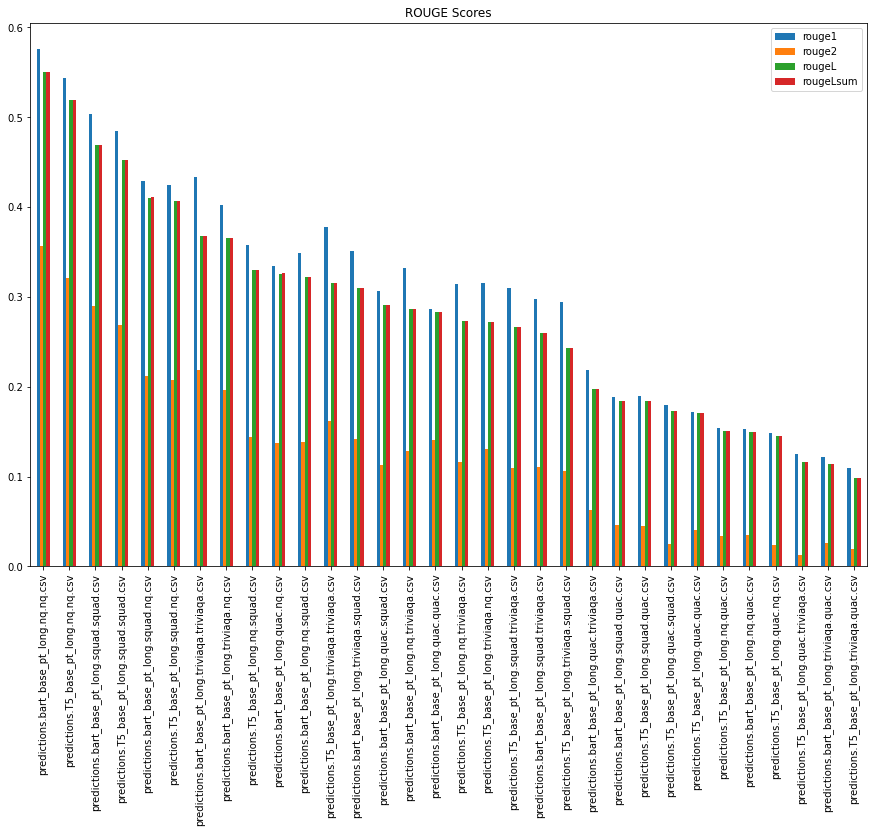

In [ ]:
rouge_fig = results_df[['rouge1', 'rouge2', 'rougeL', 'rougeLsum']].\
              sort_values(by='rougeL', ascending=False).\
              plot.bar(figsize=(15,10),
                      title='ROUGE Scores')\
              .get_figure()
rouge_fig

plot_name = join(inference_root, "rouge.png")
rouge_fig.savefig(plot_name, bbox_inches='tight')

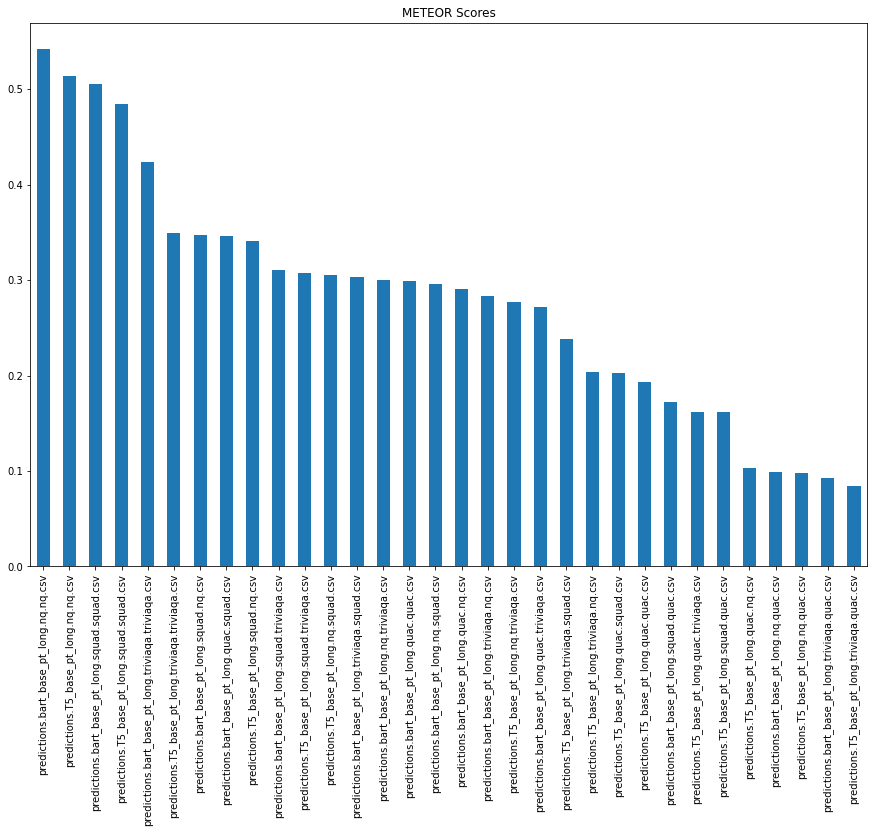

In [ ]:
meteor_fig = results_df['meteor']\
              .sort_values(ascending=False)\
              .plot.bar(figsize=(15,10),
                      title='METEOR Scores')\
              .get_figure()
meteor_fig

plot_name = join(inference_root, "meteor.png")
meteor_fig.savefig(plot_name, bbox_inches='tight')

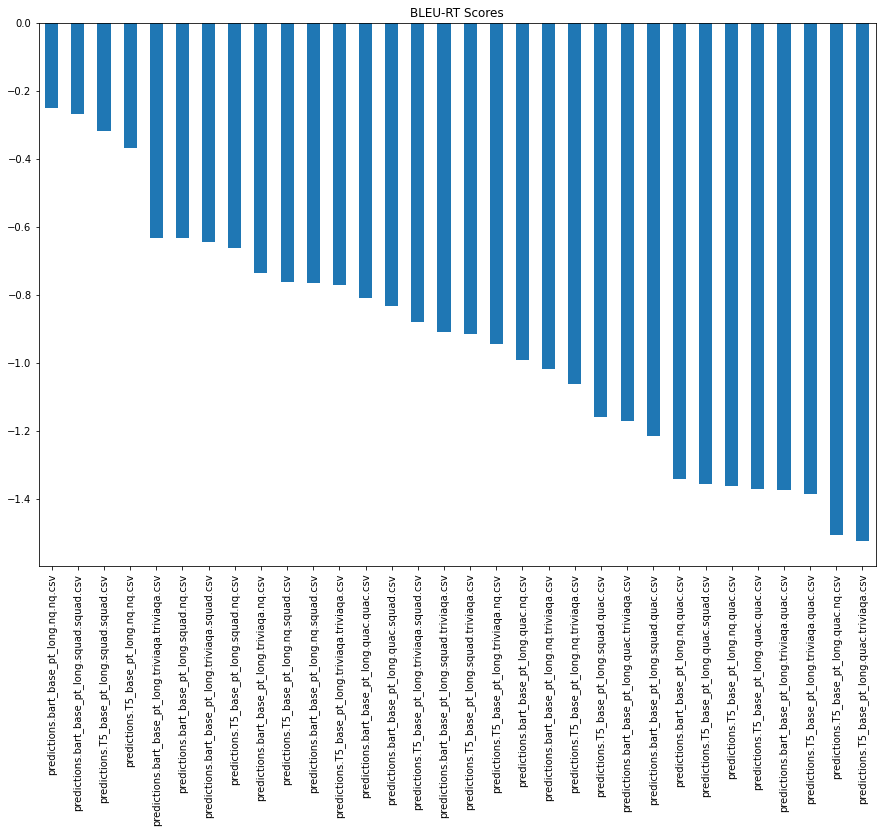

In [ ]:
bleurt_fig = results_df['bleurt']\
              .sort_values(ascending=False)\
              .plot.bar(figsize=(15,10),
           title='BLEU-RT Scores')\
           .get_figure()

bleurt_fig

plot_name = join(inference_root, "bleurt.png")
bleurt_fig.savefig(plot_name, bbox_inches='tight')

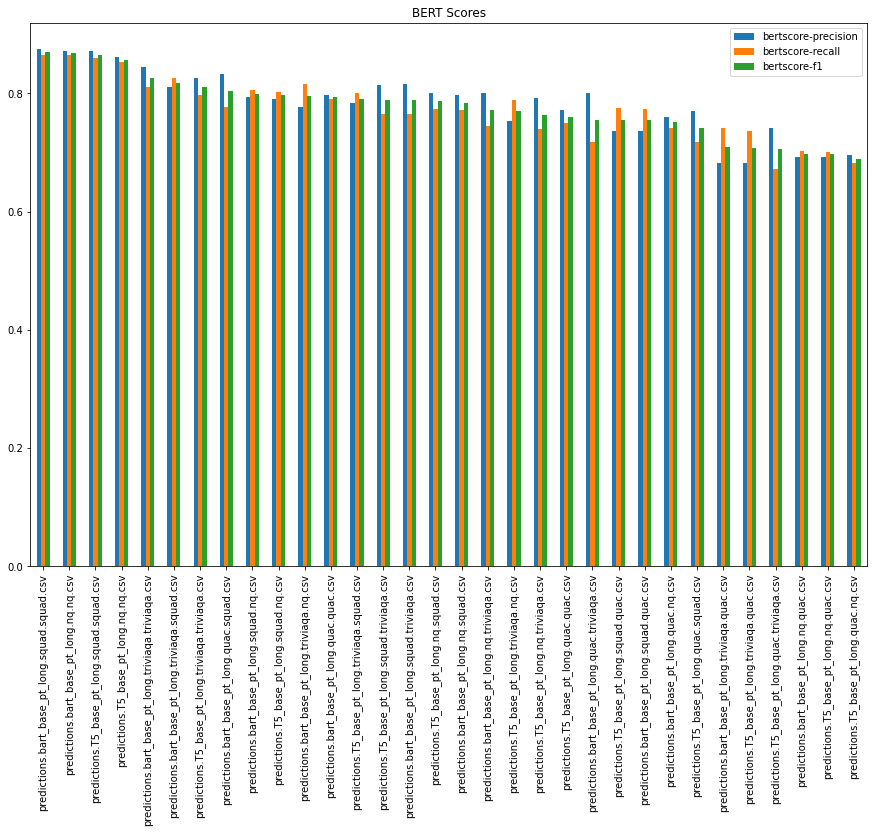

In [ ]:
bertscore_fig = results_df[['bertscore-precision', 'bertscore-recall', 'bertscore-f1']]\
                  .sort_values(by='bertscore-f1', ascending=False)\
                  .plot.bar(figsize=(15,10),
                            title='BERT Scores')\
                  .get_figure()
bertscore_fig

plot_name = join(inference_root, "bertscore.png")
bertscore_fig.savefig(plot_name, bbox_inches='tight')

# Archive

⚠️ This cell takes some time. ⚠️

In [ ]:
evaluation_dict = {}

for id, dataset in enumerate(inference_dict.keys()):

  # Get this dataset's `target` and `prediction` values
  targets = inference_dict[dataset]['target'].tolist()
  predictions = inference_dict[dataset]['prediction'].tolist()

  
  # Evaluations

  # ROUGE
  rouge_results = rouge.compute(predictions=predictions,
                                references=targets,
                                use_aggregator=False)
  evaluation_dict.update(
      {
          dataset: {'rouge': rouge_results}
      }
  )

  # BLEU-RT
  bleurt_results = bleurt.compute(predictions=predictions,
                                  references=targets)
  evaluation_dict.update(
      {
          dataset: {'bleurt': bleurt_results}
      }
  )

  # BERTScore
  bertscore_results = bertscore.compute(predictions=predictions,
                                        references=targets,
                                        model_type='distilbert-base-uncased')
  evaluation_dict.update(
      {
          dataset: {'bertscore': bleurt_results}
      }
  )

  print(f"Dataset {dataset} evaluated.")

KeyboardInterrupt: ignored